# 실습에 필요한 도구
## 1번 도구: Agent와 상호작용 할 수 있는 시뮬레이션 환경 (GYM)

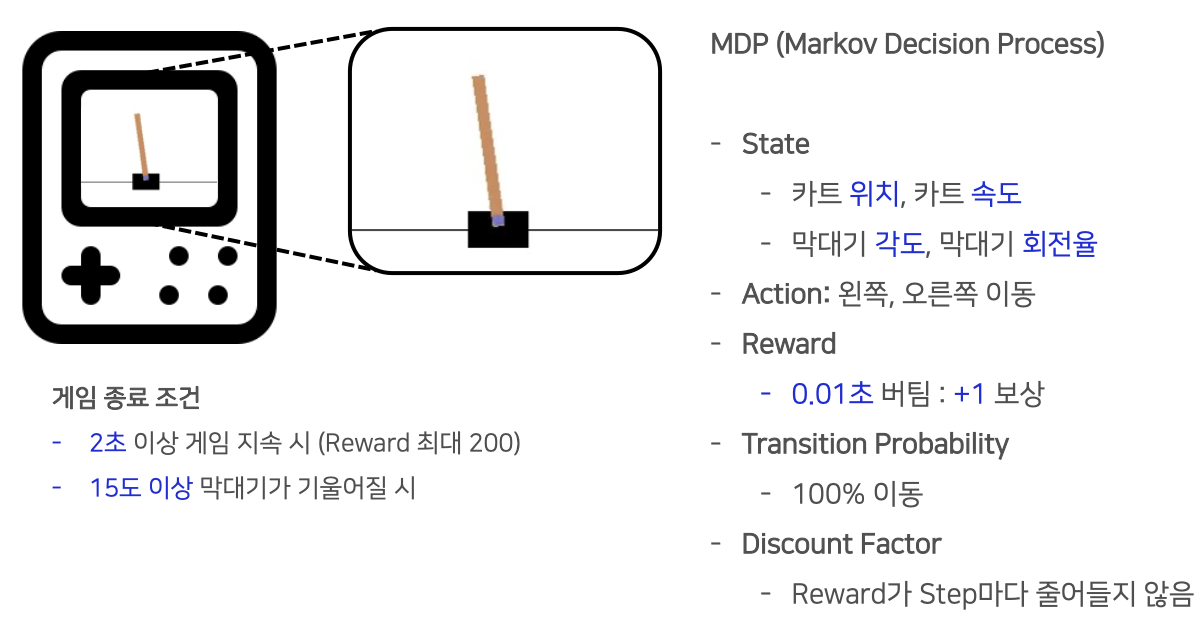

In [1]:
import copy
import gym
import numpy as np
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(134567)

env = gym.make('CartPole-v0') # Gym이라는 가상의 놀이터 중, cartpole 놀이기구
env.seed(1234567)
env.reset()                   # 가상환경 리셋


array([ 0.02038114, -0.01340702, -0.04718901, -0.03680921])

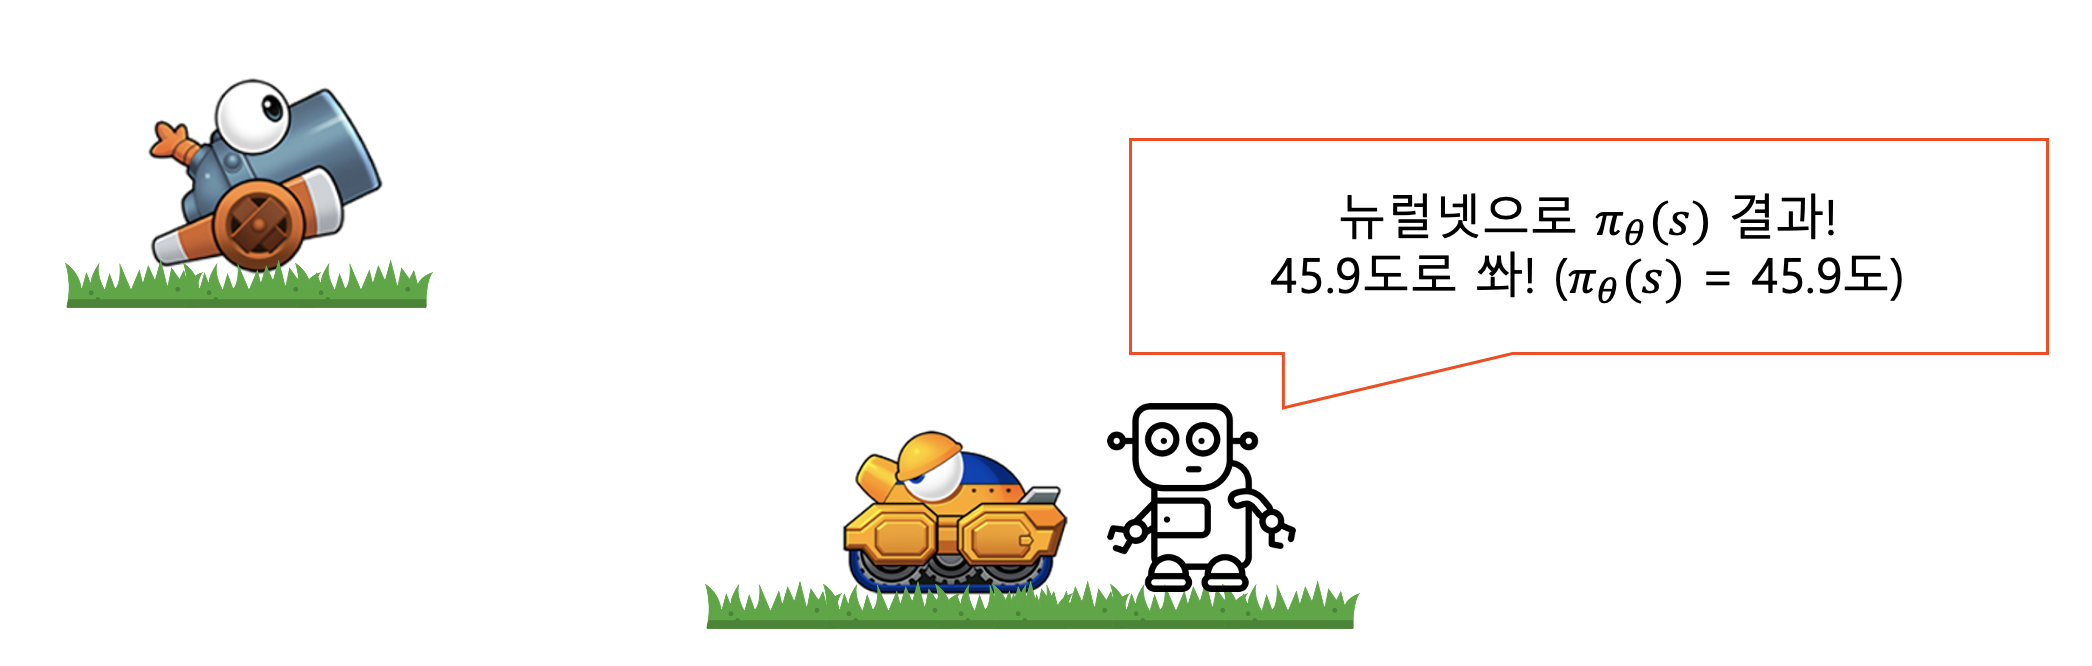

In [2]:
# 사용할 Policy용, Value용 Nerual Net 구성
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__(self)
        self.num_actions = env.action_space.n
        self.hidden_layer_0 = tf.keras.layers.Dense(units=256, activation='relu')
        self.hidden_layer_1 = tf.keras.layers.Dense(units=128, activation='relu')

        #policy out: action 수 만큼 있어야함
        self.policy_out = tf.keras.layers.Dense(units=self.num_actions, activation='tanh')

        #value out 또한 action 수 만큼 있어야함 (action_value function)
        self.value_out = tf.keras.layers.Dense(units=self.num_actions, activation='linear')

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        hidden_0 = self.hidden_layer_0(inputs)
        hidden_1 = self.hidden_layer_1(hidden_0)
        policy_val = self.policy_out(hidden_1)
        value_val = self.value_out(hidden_0)

        return policy_val, value_val

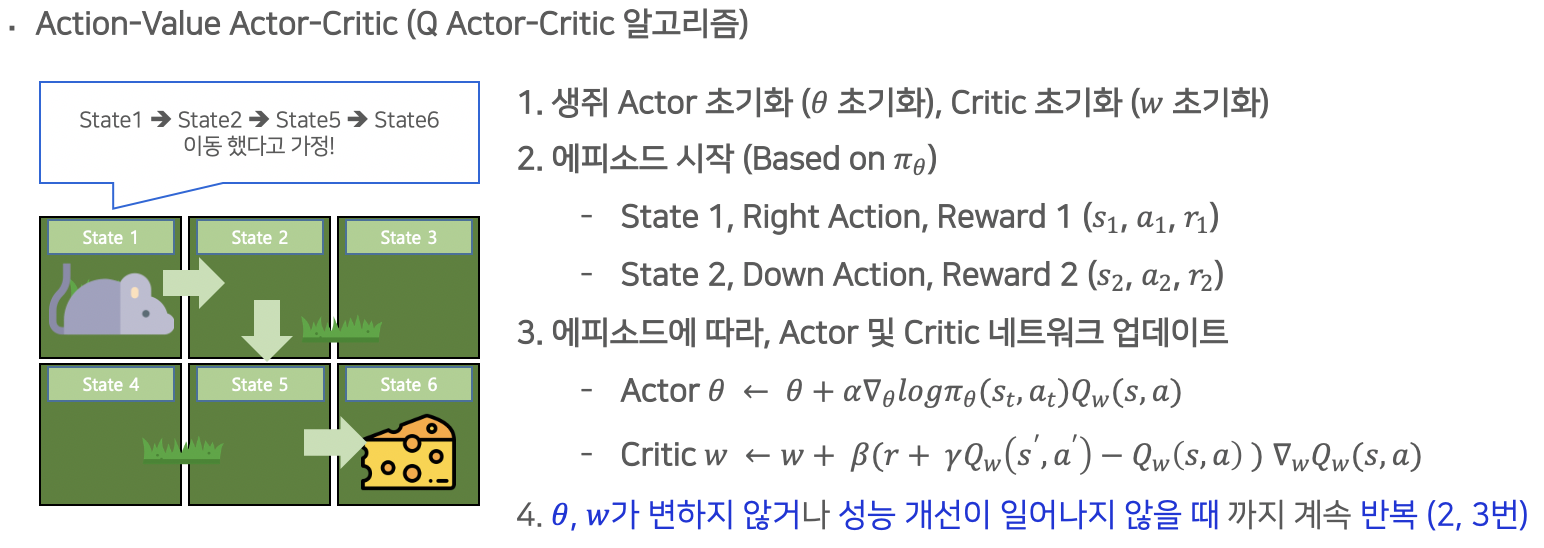

In [3]:
# Gradient들을 업데이트 할 저장창고
class Storage():
    def __init__(self):
        self.total_rewards=[]
        self.total_gradients=[]
    
    # 저장소 비우기
    def clear(self):
        self.total_rewards=[]
        self.total_gradients=[]
    
    # rewards, gradient값들 저장
    def save(self, reward, total_grads):
        gradient = [values.numpy() for values in total_grads]
        self.total_rewards.append(reward)
        self.total_gradients.append(gradient)

In [4]:
# Actor-Critic 알고리즘
class Brain:
    def __init__(self, model, storage, discount_factor, learning_rate):
        self.model = model
        self.storage = storage
        self.episode = 0
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.num_actions = env.action_space.n
        self.model.build((1, env.observation_space.shape[0]))
        self.optimizer = tf.optimizers.Adam(self.learning_rate)

    # Actor Cost function
    # -𝑙𝑜𝑔𝜋_𝜃 (s,a) * Q(s,a)
    def actor_cost_fn(self, action_list, probability, value_output):
        cost_policy = -tf.reduce_mean(tf.reduce_sum(action_list * tf.math.log(probability))) 
        cost_policy = cost_policy * value_output
        return cost_policy

    # Critic Cost function
    # 𝑤 ← 𝑤+ 𝛽(𝑟+ 𝛾 𝑄_𝑤(s′, a′) − 𝑄_𝑤(s, a)) ∇_𝑤 𝑄_𝑤 (s, a)
    def critic_cost_fn(self, value_output, Q_target):
        cost_value = tf.reduce_mean(tf.math.square(Q_target - value_output))
        return cost_value


    # Action을 확률을 고려해서 뽑아줌 (REINFORCE와 다른점 => next_exist)
    def action(self, state, next_exist=False, action_list=0):
        policy_output, value_output = self.model([state])
        
        # 만약, 이전 결과가 있다면, 그냥 그 action을 취함
        if next_exist == False:
            temp_action = tf.random.categorical(policy_output, 1)
            action = tf.one_hot(temp_action, self.num_actions)
        elif next_exist == True:
            action = action_list

        probability = tf.nn.softmax(policy_output)    
        value_output = value_output[0][np.argmax(action)]
        
        return action, probability, value_output

    # 훈련 함수
    def train(self, env):
        state = env.reset()
        total_grad_arry = self.model.trainable_variables

        for idx, grad in enumerate(total_grad_arry):
            total_grad_arry[idx] = 0

        sum_rewards = 0
        avg_rewards = []
        total_episodes = 600
        next_exist = False

        while self.episode < total_episodes:

            if self.episode > 550:
                env.render()

            # Gradient를 계산하는 공간
            with tf.GradientTape() as tape:
                if next_exist == False:
                    action_list, probability, value_output = self.action(state)
                elif next_exist == True:
                    action_list, probability, value_output = self.action(state, next_exist=True, action_list=action_list)  

                next_state, reward, done, info = env.step(np.argmax(action_list))
                
                # actor loss 계산
                actor_loss = self.actor_cost_fn(action_list, probability, value_output)

                # REINFORCE와 다른 점 => 다음 state에서 어떤 action을 할 지, 고려해야 함
                next_action_list, next_probability, next_value_output = self.action(next_state)
                Q_target = reward + self.discount_factor * next_value_output * (done==False)
                
                # REINFORCE와 다른 점 => critic loss 계산
                critic_loss = self.critic_cost_fn(value_output, Q_target)
                
                # 전체 loss
                total_loss = actor_loss + critic_loss
            
            # REINFORCE와 다른 점 => state 뿐 아니라, action까지 옮겨준다
            state = next_state
            action_list = next_action_list
            next_exist = True

            # Total_grads 계산
            total_grads = tape.gradient(total_loss, self.model.trainable_variables)
            self.storage.save(reward, total_grads)

            # 게임 종료
            if done:
                self.episode += 1
                sum_rewards = np.sum(np.array(self.storage.total_rewards))
                saved_total_gradient = np.array(self.storage.total_gradients)            

                # 저장된 Gradient들을 업데이트 수행
                for grads in saved_total_gradient:
                    for idx, grad in enumerate(grads):
                        total_grad_arry[idx] += grad / len(saved_total_gradient)

                avg_rewards.append(sum_rewards)
                self.optimizer.apply_gradients(zip(total_grad_arry, model.trainable_variables))

                # 최근 10회 마다 reward의 평균을 출력
                if self.episode != 0 and self.episode %10 == 0:
                    avg_val = sum(avg_rewards[self.episode-10:self.episode])
                    avg_val = avg_val/10
                    print("가장 최근, 10회 평균 Reward는 {} 입니닷!".format(avg_val))

                    #grad_arry 초기화
                    for idx, grad in enumerate(total_grad_arry):
                        total_grad_arry[idx] = 0

                self.storage.clear()
                state = env.reset()
                next_exist = False

In [5]:
discount_factor = 0.99
learning_rate = 0.0007

model = Model()
storage = Storage()
agent = Brain(model, storage, discount_factor, learning_rate)
agent.train(env)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


가장 최근, 10회 평균 Reward는 25.4 입니닷!
가장 최근, 10회 평균 Reward는 16.0 입니닷!
가장 최근, 10회 평균 Reward는 16.5 입니닷!
가장 최근, 10회 평균 Reward는 12.2 입니닷!
가장 최근, 10회 평균 Reward는 17.0 입니닷!
가장 최근, 10회 평균 Reward는 14.7 입니닷!
가장 최근, 10회 평균 Reward는 13.8 입니닷!
가장 최근, 10회 평균 Reward는 13.3 입니닷!
가장 최근, 10회 평균 Reward는 12.6 입니닷!
가장 최근, 10회 평균 Reward는 13.8 입니닷!
가장 최근, 10회 평균 Reward는 15.7 입니닷!
가장 최근, 10회 평균 Reward는 16.6 입니닷!
가장 최근, 10회 평균 Reward는 21.0 입니닷!
가장 최근, 10회 평균 Reward는 18.6 입니닷!
가장 최근, 10회 평균 Reward는 15.5 입니닷!
가장 최근, 10회 평균 Reward는 14.7 입니닷!
가장 최근, 10회 평균 Reward는 21.9 입니닷!
가장 최근, 10회 평균 Reward는 14.2 입니닷!
가장 최근, 10회 평균 Reward는 31.0 입니닷!
가장 최근, 10회 평균 Reward는 33.4 입니닷!
가장 최근, 10회 평균 Reward는 28.4 입니닷!
가장 최근, 10회 평균 Reward는 35.6 입니닷!
가장 최근, 10회 평균 Reward는 20.0 입니닷!
가장 최근, 10회 평균 Reward는 15.4 입니닷!
가장 최근, 10회 평균 Reward는 15.0 입니닷!
가장 최근, 10회 평균 Reward는 20.2 입니닷!
가장 최근, 10회 평균 Reward는 26.2 입니닷!
가장 최근, 10회 평균 Reward는 24.6 입니닷!
가장 최근, 10회 평균 Reward는 30.9 입니닷!
가장 최근, 10회 평균 Reward는 37.1 입니닷!
가장 최근, 10회 평균 Reward는 31.7 입니닷!
가장 최근, 1